# Imports and Functions

In [1]:
import math 
import matplotlib
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model

import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 4 #0 for 0.5, 1 for isolated, 2 for random, 3 for best, 4 for sim_anneal

global threshold
threshold = 20 

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zbranin
    global xx,yy
    global Big_df
    global Big_df_land
    global clf


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = MLPClassifier(alpha=0.3, max_iter=3000, solver = 'lbfgs')
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zbranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        Zbranin.append(braninColor(branincoords[i],threshold))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zbranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [4]:
def StaticPen(x):

    if(wales.contains_point(x)):
        pen = 1
    else:
        pen = 0

    dist = (tree.query([x], k=1)[0])
    prob = clf.predict_proba([x])[0][0]
    tmp_score = (0.5-np.abs(0.5-prob))*dist

    return tmp_score*pen

def sim_anneal_best():
    
    global tree
    
    tree = KDTree(X, leaf_size=40)

    lower_bound = np.array([-5,-2])
    upper_bound = np.array([51,53])
    max_iter = 1000
    stdevscale = 0.2*(upper_bound-lower_bound)
    gamma = 0.35
    t_initial = 1000
    r = 100
    beta = 1

    import math
    from scipy.stats import truncnorm
    global Xdash,Ydash




    Xbest = np.random.uniform(low  = lower_bound,    
                          high = upper_bound,        
                          size = (len(lower_bound)))

    Ybest = StaticPen(Xbest)
    Xcenter = Xbest                                          
    Ycenter = Ybest
    t_k=t_initial

    for k in range(max_iter-1):  

        Xdash = truncnorm.rvs((lower_bound - Xcenter)/stdevscale,(upper_bound-Xcenter)    
                              /stdevscale,loc=Xcenter,scale=stdevscale)          

        Ydash = StaticPen(Xdash)
        deltaY = Ydash - Ycenter

        if deltaY<=0 or np.random.rand()<min((math.exp(-deltaY/t_k)),1):
            Xcenter = Xdash
            Ycenter = Ydash                               

            if Ydash>Ybest:
                Xbest=Xdash
                Ybest=Ydash

                t_k = t_k*gamma    

    ax.scatter(Xbest[0],Xbest[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
    print('sim_anneal_isolated coord:',(Xbest[0],Xbest[1]),'distance:',Ybest)
    
    return np.array([Xbest[0],Xbest[1]])

In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

In [7]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


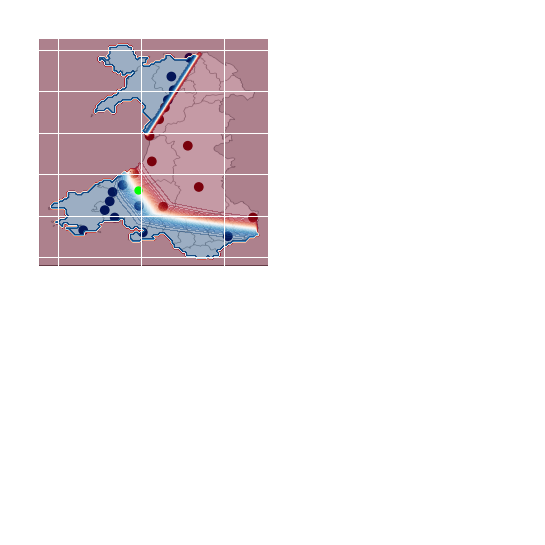

iteration  1
Accuracy is 0.5670063449336666
sim_anneal_isolated coord: (6.0100378017210145, 6.5198576086286515) distance: [[14.45318026]]
iteration  2
Accuracy is 0.5800807537012113
sim_anneal_isolated coord: (22.53792175248685, 23.117251748393123) distance: [[4.04906553]]
iteration  3
Accuracy is 0.5633532013074409
sim_anneal_isolated coord: (24.30002610014713, 33.266677934143296) distance: [[2.82711557]]
iteration  4
Accuracy is 0.5370121130551817
sim_anneal_isolated coord: (13.086101166336404, 15.744916616532624) distance: [[5.75083462]]
iteration  5
Accuracy is 0.5583541626610268
sim_anneal_isolated coord: (31.575320013091535, 48.08014947301153) distance: [[1.95872255]]
iteration  6
Accuracy is 0.5485483560853682
sim_anneal_isolated coord: (11.203847153514745, 11.383393285801896) distance: [[2.36140764]]
iteration  7
Accuracy is 0.5633532013074409
sim_anneal_isolated coord: (26.403258488218263, 37.91548900177666) distance: [[2.13607785]]
iteration  8
Accuracy is 0.5687367813881946


<IPython.core.display.Javascript object>


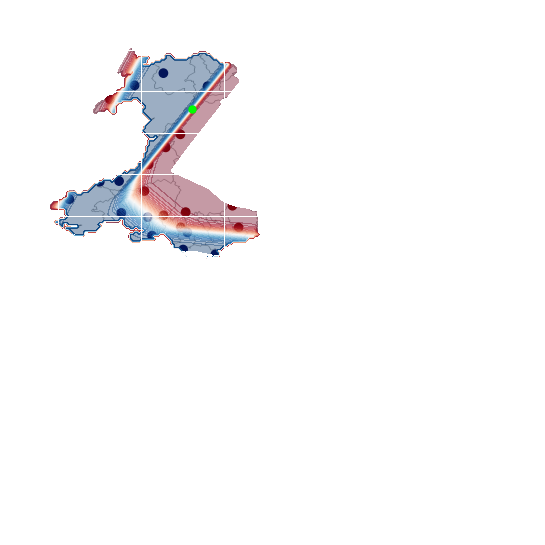

iteration  1
Accuracy is 0.4439530859450106
sim_anneal_isolated coord: (22.585390721674074, 5.24427545555451) distance: [[2.75444019]]
iteration  2
Accuracy is 0.4858681022880215
sim_anneal_isolated coord: (12.457400196455897, 38.03536205647936) distance: [[14.97241748]]
iteration  3
Accuracy is 0.5481638146510287
sim_anneal_isolated coord: (30.691517397383755, 10.895176319631098) distance: [[4.15470198]]
iteration  4
Accuracy is 0.5435493174389541
sim_anneal_isolated coord: (9.99565203434722, 18.227875908068885) distance: [[5.11536605]]
iteration  5
Accuracy is 0.5535473947317824
sim_anneal_isolated coord: (20.754443992061088, 15.967988203541681) distance: [[4.53076827]]
iteration  6
Accuracy is 0.554701019034801
sim_anneal_isolated coord: (37.844399998646665, 0.7355276269610069) distance: [[2.41026641]]
iteration  7
Accuracy is 0.5635454720246107
sim_anneal_isolated coord: (14.646102248391381, 18.38145888384271) distance: [[2.24616062]]
iteration  8
Accuracy is 0.571813112862911
sim_

<IPython.core.display.Javascript object>


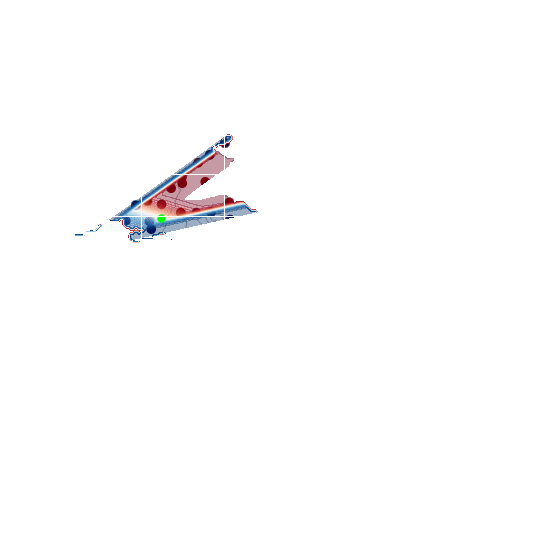

iteration  1
Accuracy is 0.44568352239953857
sim_anneal_isolated coord: (22.40351551023617, 6.797423505432762) distance: [[2.83681817]]
iteration  2
Accuracy is 0.4531820803691598
sim_anneal_isolated coord: (6.862755650445967, 7.094924599435407) distance: [[7.07684882]]
iteration  3
Accuracy is 0.6617958084983657
sim_anneal_isolated coord: (35.41950470327217, 18.19674181538253) distance: [[4.51897233]]
iteration  4
Accuracy is 0.6198807921553547
sim_anneal_isolated coord: (21.247818386256903, 42.076526094092394) distance: [[10.72380284]]
iteration  5
Accuracy is 0.6591040184579888
sim_anneal_isolated coord: (38.56148010429411, 43.94494908750469) distance: [[8.47528258]]
iteration  6
Accuracy is 0.7006344933666603
sim_anneal_isolated coord: (38.38940315032759, 32.15538914864495) distance: [[4.70455265]]
iteration  7
Accuracy is 0.6983272447606229
sim_anneal_isolated coord: (36.47622638006042, 24.692353823139587) distance: [[2.95405777]]
iteration  8
Accuracy is 0.6869832724476063
sim_an

<IPython.core.display.Javascript object>


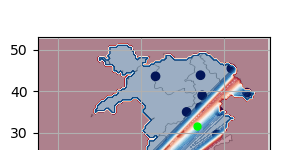

iteration  1
Accuracy is 0.5458565660449913
sim_anneal_isolated coord: (23.428796949002408, 43.612289849562956) distance: [[11.3437752]]
iteration  2
Accuracy is 0.6004614497212074
sim_anneal_isolated coord: (25.985751862063534, 26.38287756848796) distance: [[8.2178258]]
iteration  3
Accuracy is 0.5427802345702749
sim_anneal_isolated coord: (16.55529727673422, 20.22668612951566) distance: [[4.68359903]]
iteration  4
Accuracy is 0.5781580465295135
sim_anneal_isolated coord: (34.26492376218194, 43.873194672033) distance: [[4.51958468]]
iteration  5
Accuracy is 0.5881561238223418
sim_anneal_isolated coord: (7.391877369073049, 6.910706834820251) distance: [[3.49575679]]
iteration  6
Accuracy is 0.5908479138627187
sim_anneal_isolated coord: (14.184409507982206, 12.754678793669168) distance: [[3.64410788]]
iteration  7
Accuracy is 0.5962314939434724
sim_anneal_isolated coord: (30.922996841491695, 35.02801984182419) distance: [[3.46194048]]
iteration  8
Accuracy is 0.6143049413574313
sim_anne

<IPython.core.display.Javascript object>


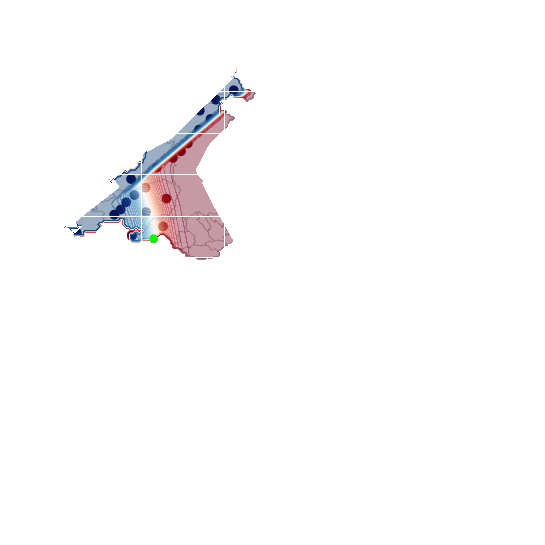

iteration  1
Accuracy is 0.6044991347817728
sim_anneal_isolated coord: (4.429721677219063, 5.949259556737193) distance: [[13.82613725]]
iteration  2
Accuracy is 0.6156508363776196
sim_anneal_isolated coord: (16.3586226488422, 13.27335173775912) distance: [[4.57185185]]
iteration  3
Accuracy is 0.648721399730821
sim_anneal_isolated coord: (37.91722824629588, 19.87040663399013) distance: [[3.16549458]]
iteration  4
Accuracy is 0.6135358584887521
sim_anneal_isolated coord: (21.01224611611132, 16.796685110377712) distance: [[2.64696563]]
iteration  5
Accuracy is 0.6100749855796962
sim_anneal_isolated coord: (34.08236547767906, 35.34290545837716) distance: [[3.36931106]]
iteration  6
Accuracy is 0.6269948086906364
sim_anneal_isolated coord: (23.736081723354943, 21.612153259170697) distance: [[1.75277382]]
iteration  7
Accuracy is 0.6252643722361084
sim_anneal_isolated coord: (18.335836219137498, 15.012946600640483) distance: [[1.20640306]]
iteration  8
Accuracy is 0.6435300903672371
sim_ann

<IPython.core.display.Javascript object>


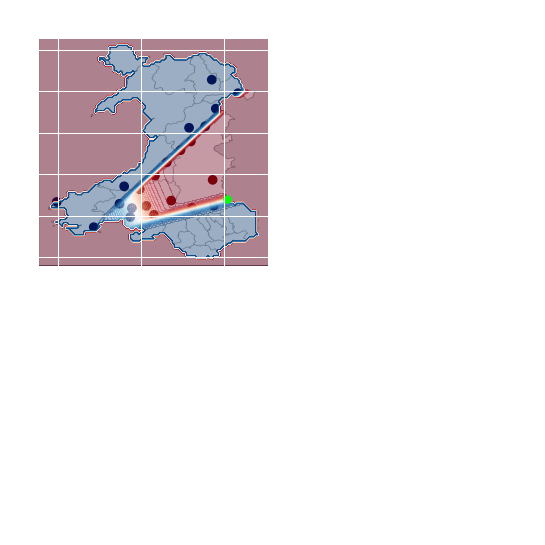

iteration  1
Accuracy is 0.38646414151124786
sim_anneal_isolated coord: (17.335757358113565, 9.721091169028476) distance: [[5.08701908]]
iteration  2
Accuracy is 0.4645260526821765
sim_anneal_isolated coord: (37.1874240834271, 18.675499210381517) distance: [[2.03302874]]
iteration  3
Accuracy is 0.5041338204191501
sim_anneal_isolated coord: (-0.370613364457105, 13.341471921753339) distance: [[5.7169689]]
iteration  4
Accuracy is 0.5206691020957508
sim_anneal_isolated coord: (15.873955162335331, 17.11965262466203) distance: [[2.47302253]]
iteration  5
Accuracy is 0.6416073831955393
sim_anneal_isolated coord: (36.976222371035334, 42.79853152149209) distance: [[9.55716089]]
iteration  6
Accuracy is 0.6679484714477985
sim_anneal_isolated coord: (31.504644852134632, 31.21785999597912) distance: [[4.54142615]]
iteration  7
Accuracy is 0.677754278023457
sim_anneal_isolated coord: (27.20036855862721, 13.667583105438737) distance: [[3.50583184]]
iteration  8
Accuracy is 0.7006344933666603
sim_a

<IPython.core.display.Javascript object>


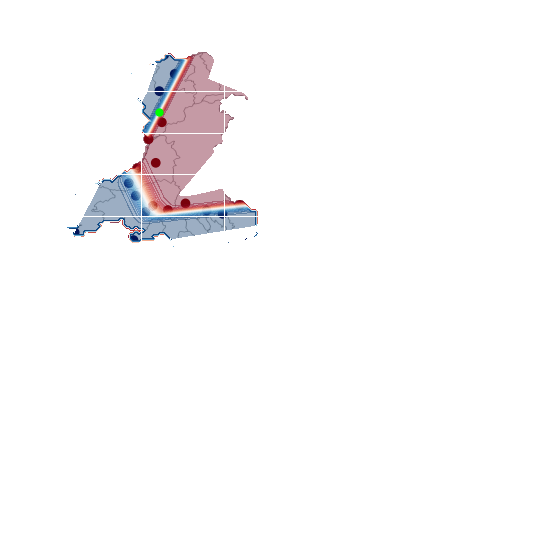

iteration  1
Accuracy is 0.5593155162468756
sim_anneal_isolated coord: (3.9568444977376114, 6.013976562564343) distance: [[12.64989587]]
iteration  2
Accuracy is 0.5620073062872525
sim_anneal_isolated coord: (24.950017550254962, 32.53295498739904) distance: [[7.42511096]]
iteration  3
Accuracy is 0.5362430301865025
sim_anneal_isolated coord: (16.99899718270258, 17.870713909080322) distance: [[3.78408782]]
iteration  4
Accuracy is 0.577004422226495
sim_anneal_isolated coord: (18.12506377242868, 4.163647728364585) distance: [[5.73620613]]
iteration  5
Accuracy is 0.5702749471255528
sim_anneal_isolated coord: (22.753278762786564, 12.39858830115433) distance: [[3.55622153]]
iteration  6
Accuracy is 0.5831570851759277
sim_anneal_isolated coord: (21.10464453883608, 43.02967172493278) distance: [[2.8441122]]
iteration  7
Accuracy is 0.5852720630647952
sim_anneal_isolated coord: (25.516198066272583, 48.76464740209265) distance: [[3.24953233]]
iteration  8
Accuracy is 0.5966160353778119
sim_ann

<IPython.core.display.Javascript object>


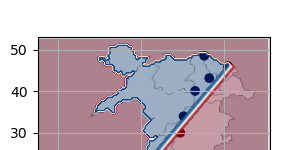

iteration  1
Accuracy is 0.5985387425495097
sim_anneal_isolated coord: (8.077627884755227, 9.473315517587572) distance: [[8.8175988]]
iteration  2
Accuracy is 0.6033455104787541
sim_anneal_isolated coord: (29.383682800422246, 30.00388701102347) distance: [[6.18236405]]
iteration  3
Accuracy is 0.5860411459334743
sim_anneal_isolated coord: (15.32580895232363, 13.788609259486512) distance: [[4.0261343]]
iteration  4
Accuracy is 0.5852720630647952
sim_anneal_isolated coord: (32.96856915711556, 40.088674932181846) distance: [[4.23779074]]
iteration  5
Accuracy is 0.6000769082868679
sim_anneal_isolated coord: (24.596376205935996, 25.007249858664665) distance: [[3.2288214]]
iteration  6
Accuracy is 0.5998846375696981
sim_anneal_isolated coord: (20.942387658371523, 20.863913159617457) distance: [[2.58997807]]
iteration  7
Accuracy is 0.6089213612766775
sim_anneal_isolated coord: (17.51933758637889, 17.032600220853134) distance: [[1.86508794]]
iteration  8
Accuracy is 0.6131513170544126
sim_an

<IPython.core.display.Javascript object>


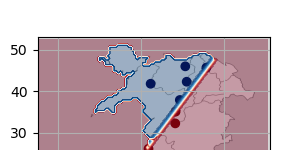

iteration  1
Accuracy is 0.551240146125745
sim_anneal_isolated coord: (24.06436818942486, 5.626155976720504) distance: [[9.48731157]]
iteration  2
Accuracy is 0.5391270909440492
sim_anneal_isolated coord: (25.752267936227, 18.004440272552344) distance: [[3.93022309]]
iteration  3
Accuracy is 0.5616227648529128
sim_anneal_isolated coord: (37.701733105877594, 6.333857751419316) distance: [[5.8879032]]
iteration  4
Accuracy is 0.5441261295904634
sim_anneal_isolated coord: (47.3094627096004, 10.883210962911207) distance: [[4.51753464]]
iteration  5
Accuracy is 0.5696981349740434
sim_anneal_isolated coord: (12.657821918324919, 16.938102282658942) distance: [[4.11096606]]
iteration  6
Accuracy is 0.5764276100749856
sim_anneal_isolated coord: (29.721453997781815, 12.213352035063684) distance: [[2.20865932]]
iteration  7
Accuracy is 0.6035377811959238
sim_anneal_isolated coord: (21.90228318972399, 12.761709040621243) distance: [[3.04222655]]
iteration  8
Accuracy is 0.639300134589502
sim_annea

<IPython.core.display.Javascript object>


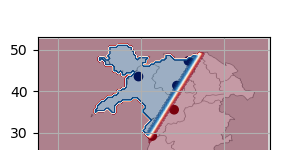

iteration  1
Accuracy is 0.5049029032878293
sim_anneal_isolated coord: (31.359549574098715, 47.319557047766125) distance: [[5.46165099]]
iteration  2
Accuracy is 0.5466256489136705
sim_anneal_isolated coord: (6.165519024827159, 10.915806500374478) distance: [[4.60635196]]
iteration  3
Accuracy is 0.562391847721592
sim_anneal_isolated coord: (27.901091844509878, 35.5629604790012) distance: [[5.61774672]]
iteration  4
Accuracy is 0.5348971351663142
sim_anneal_isolated coord: (13.407513549741099, 17.19898745920633) distance: [[3.4827701]]
iteration  5
Accuracy is 0.5570082676408383
sim_anneal_isolated coord: (22.62826193130293, 29.22447119765102) distance: [[3.77011041]]
iteration  6
Accuracy is 0.5464333781965006
sim_anneal_isolated coord: (12.534875754958641, 13.248205618514069) distance: [[1.22969727]]
iteration  7
Accuracy is 0.568352239953855
sim_anneal_isolated coord: (28.582830380334695, 41.38228338496903) distance: [[1.67896278]]
iteration  8
Accuracy is 0.5737358200346088
sim_ann

<IPython.core.display.Javascript object>


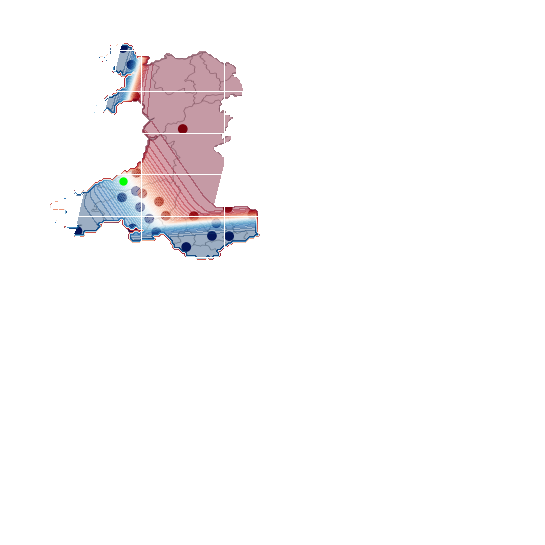

iteration  1
Accuracy is 0.5608536819842338
sim_anneal_isolated coord: (15.577506660300031, 50.42552717641618) distance: [[20.5487054]]
iteration  2
Accuracy is 0.5377811959238608
sim_anneal_isolated coord: (29.985691293867696, 30.915969245390585) distance: [[10.04356769]]
iteration  3
Accuracy is 0.5650836377619689
sim_anneal_isolated coord: (18.82665397799325, 20.377717486621243) distance: [[7.42750001]]
iteration  4
Accuracy is 0.5112478369544319
sim_anneal_isolated coord: (18.515143253186363, 38.80113955833368) distance: [[5.51475116]]
iteration  5
Accuracy is 0.4739473178234955
sim_anneal_isolated coord: (15.347622311732753, 14.446364039918823) distance: [[0.14123036]]
iteration  6
Accuracy is 0.539319361661219
sim_anneal_isolated coord: (17.90017405869478, 6.964280348276979) distance: [[3.02331327]]
iteration  7
Accuracy is 0.5695058642568737
sim_anneal_isolated coord: (23.616310580617714, 6.099763507617651) distance: [[2.25321622]]
iteration  8
Accuracy is 0.5827725437415882
sim

<IPython.core.display.Javascript object>


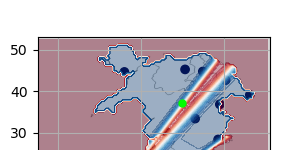

iteration  1
Accuracy is 0.4845222072678331
sim_anneal_isolated coord: (8.769493131549206, 14.189525300233285) distance: [[9.67291698]]
iteration  2
Accuracy is 0.5568159969236686
sim_anneal_isolated coord: (19.20029089244714, 21.172722423172733) distance: [[3.86550534]]
iteration  3
Accuracy is 0.5241299750048067
sim_anneal_isolated coord: (12.895335034418814, 18.342442555012845) distance: [[1.32642244]]
iteration  4
Accuracy is 0.5372043837723515
sim_anneal_isolated coord: (15.186598113834796, 11.589240142147865) distance: [[2.56597614]]
iteration  5
Accuracy is 0.5873870409536628
sim_anneal_isolated coord: (27.293091134255285, 5.225048049561105) distance: [[6.37228171]]
iteration  6
Accuracy is 0.5818111901557392
sim_anneal_isolated coord: (30.544609587209873, 45.27279282444918) distance: [[6.90589741]]
iteration  7
Accuracy is 0.5662372620649875
sim_anneal_isolated coord: (38.502519215161406, 28.39985842471724) distance: [[5.01921251]]
iteration  8
Accuracy is 0.5233608921361277
si

<IPython.core.display.Javascript object>


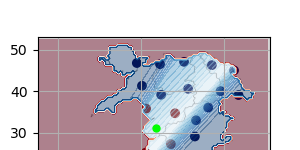

iteration  1
Accuracy is 0.3906940972889829
sim_anneal_isolated coord: (8.221101315882564, 7.952668629164769) distance: [[10.74688365]]
iteration  2
Accuracy is 0.4016535281676601
sim_anneal_isolated coord: (27.112705901231745, 27.300265744391517) distance: [[2.57642892]]
iteration  3
Accuracy is 0.39011728513747357
sim_anneal_isolated coord: (2.341074640161832, 7.20064052587834) distance: [[1.33001983]]
iteration  4
Accuracy is 0.43972313016727554
sim_anneal_isolated coord: (43.41475982949787, 39.091999497889944) distance: [[5.11827098]]
iteration  5
Accuracy is 0.4766391078638723
sim_anneal_isolated coord: (18.918669472616216, 46.810610975523815) distance: [[9.63486216]]
iteration  6
Accuracy is 0.5054797154393386
sim_anneal_isolated coord: (10.208663629009505, 13.805149859949179) distance: [[2.93578629]]
iteration  7
Accuracy is 0.5231686214189579
sim_anneal_isolated coord: (21.1498649712601, 35.83037843509539) distance: [[3.82115797]]
iteration  8
Accuracy is 0.5095174004999039
sim

<IPython.core.display.Javascript object>


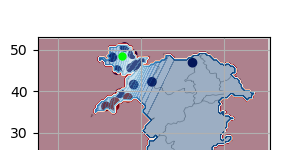

iteration  1
Accuracy is 0.5216304556815997
sim_anneal_isolated coord: (5.992715705369561, 7.4260856086292755) distance: [[9.93549419]]
iteration  2
Accuracy is 0.5466256489136705
sim_anneal_isolated coord: (22.548032170702054, 42.28143928391755) distance: [[4.98143965]]
iteration  3
Accuracy is 0.5535473947317824
sim_anneal_isolated coord: (7.974139436035193, 16.38190399515421) distance: [[1.91142217]]
iteration  4
Accuracy is 0.5677754278023457
sim_anneal_isolated coord: (18.171561662909966, 41.62562719434679) distance: [[1.46650132]]
iteration  5
Accuracy is 0.5691213228225341
sim_anneal_isolated coord: (2.4967624782891065, 7.057539459184975) distance: [[1.61389792]]
iteration  6
Accuracy is 0.5762353393578158
sim_anneal_isolated coord: (19.70175931806953, 47.26007634501267) distance: [[2.36221219]]
iteration  7
Accuracy is 0.5771966929436647
sim_anneal_isolated coord: (3.621725898509028, 13.005991630060539) distance: [[2.1265188]]
iteration  8
Accuracy is 0.5839261680446068
sim_ann

<IPython.core.display.Javascript object>


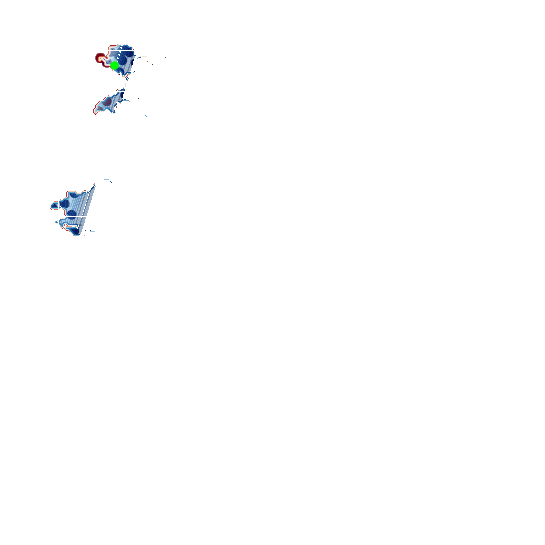

iteration  1
Accuracy is 0.4226110363391655
sim_anneal_isolated coord: (33.27017121063503, 27.143921466087676) distance: [[6.46962734]]
iteration  2
Accuracy is 0.5020188425302826
sim_anneal_isolated coord: (37.16003409909326, 46.76932371811893) distance: [[9.87438749]]
iteration  3
Accuracy is 0.5212459142472602
sim_anneal_isolated coord: (22.5700929607602, 41.31051036557573) distance: [[7.04870515]]
iteration  4
Accuracy is 0.5585464333781965
sim_anneal_isolated coord: (3.85639895012752, 6.3623948955057665) distance: [[5.66758783]]
iteration  5
Accuracy is 0.5750817150547971
sim_anneal_isolated coord: (3.9370953046811685, 15.429659142947244) distance: [[3.77114179]]
iteration  6
Accuracy is 0.5762353393578158
sim_anneal_isolated coord: (16.136727686958196, 39.1044206500684) distance: [[3.06758958]]
iteration  7
Accuracy is 0.5933474331859258
sim_anneal_isolated coord: (18.62350013296082, 46.76971680319217) distance: [[2.15580556]]
iteration  8
Accuracy is 0.5946933282061142
sim_annea

<IPython.core.display.Javascript object>


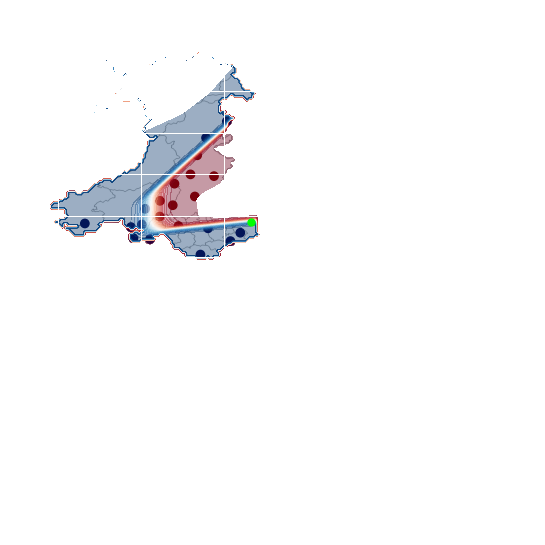

iteration  1
Accuracy is 0.6423764660642184
sim_anneal_isolated coord: (6.4061689234136345, 8.165920282661254) distance: [[8.5679087]]
iteration  2
Accuracy is 0.6360315323976159
sim_anneal_isolated coord: (35.59978355399655, 28.800693282193226) distance: [[5.19234395]]
iteration  3
Accuracy is 0.633339742357239
sim_anneal_isolated coord: (20.944065716926602, 11.69569247512563) distance: [[6.15714909]]
iteration  4
Accuracy is 0.6250721015189387
sim_anneal_isolated coord: (27.574959529770847, 12.557195189278419) distance: [[2.02611447]]
iteration  5
Accuracy is 0.60680638338781
sim_anneal_isolated coord: (37.50941955209254, 19.568812425553993) distance: [[3.29420766]]
iteration  6
Accuracy is 0.6314170351855413
sim_anneal_isolated coord: (31.849985558374634, 19.98868433876258) distance: [[2.48766557]]
iteration  7
Accuracy is 0.6344933666602577
sim_anneal_isolated coord: (40.60600809201239, 32.776094095820675) distance: [[2.04419702]]
iteration  8
Accuracy is 0.6369928859834647
sim_ann

<IPython.core.display.Javascript object>


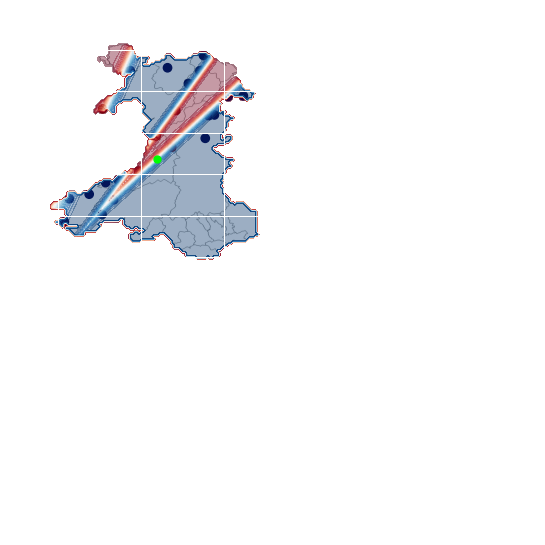

iteration  1
Accuracy is 0.500865218227264
sim_anneal_isolated coord: (11.423115284519069, 18.01656920606576) distance: [[1.2949848]]
iteration  2
Accuracy is 0.5187463949240531
sim_anneal_isolated coord: (10.671928322208746, 35.763733848421396) distance: [[6.24224556]]
iteration  3
Accuracy is 0.5481638146510287
sim_anneal_isolated coord: (14.505106324511171, 18.61786683691478) distance: [[0.89916772]]
iteration  4
Accuracy is 0.5058642568736781
sim_anneal_isolated coord: (34.97981615657113, 48.6371811058685) distance: [[11.11796977]]
iteration  5
Accuracy is 0.5314362622572583
sim_anneal_isolated coord: (17.32476354797669, 44.95809526499245) distance: [[4.88782114]]
iteration  6
Accuracy is 0.5381657373582004
sim_anneal_isolated coord: (28.294354402018502, 35.38721393835567) distance: [[6.82916013]]
iteration  7
Accuracy is 0.5304749086714093
sim_anneal_isolated coord: (10.529067015413052, 10.339027169070508) distance: [[2.21982518]]
iteration  8
Accuracy is 0.5404729859642377
sim_an

<IPython.core.display.Javascript object>


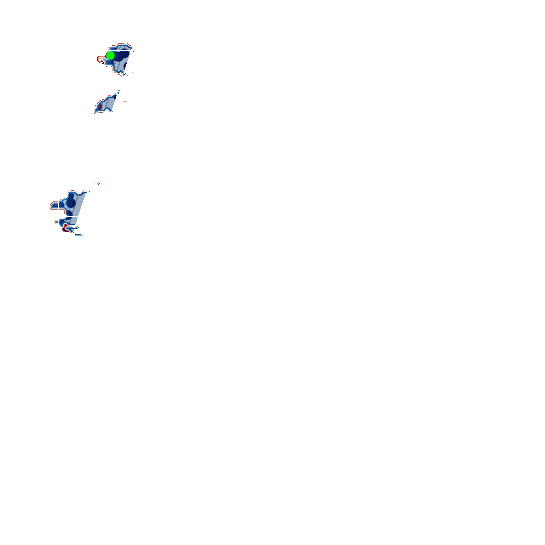

iteration  1
Accuracy is 0.5481638146510287
sim_anneal_isolated coord: (8.153630699392966, 9.025604203761672) distance: [[9.24164102]]
iteration  2
Accuracy is 0.58123437800423
sim_anneal_isolated coord: (14.458885835463716, 38.76853405154709) distance: [[4.70827057]]
iteration  3
Accuracy is 0.5968083060949817
sim_anneal_isolated coord: (3.0777831846216275, 13.068844933185655) distance: [[2.92205439]]
iteration  4
Accuracy is 0.5875793116708325
sim_anneal_isolated coord: (16.889646793956405, 45.92355911215614) distance: [[3.4508211]]
iteration  5
Accuracy is 0.6081522784079985
sim_anneal_isolated coord: (-1.6742750687077543, 12.658348785531356) distance: [[2.05319756]]
iteration  6
Accuracy is 0.6094981734281869
sim_anneal_isolated coord: (9.409491208596108, 36.34526522445914) distance: [[2.09603996]]
iteration  7
Accuracy is 0.6039223226302635
sim_anneal_isolated coord: (15.914205873503029, 49.13647855739418) distance: [[1.46362009]]
iteration  8
Accuracy is 0.6081522784079985
sim_an

<IPython.core.display.Javascript object>


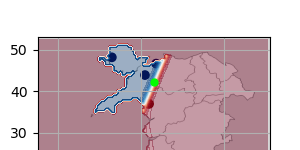

iteration  1
Accuracy is 0.39184772159200154
sim_anneal_isolated coord: (19.170806872418098, 9.683578721650763) distance: [[8.42495367]]
iteration  2
Accuracy is 0.49413574312632186
sim_anneal_isolated coord: (37.60111746358831, 18.868505914707555) distance: [[3.00579216]]
iteration  3
Accuracy is 0.5262449528936743
sim_anneal_isolated coord: (15.668360307213147, 17.09215327614899) distance: [[3.98041392]]
iteration  4
Accuracy is 0.5083637761968852
sim_anneal_isolated coord: (19.718343357480347, 21.543849867711085) distance: [[3.00789858]]
iteration  5
Accuracy is 0.5262449528936743
sim_anneal_isolated coord: (24.264352769013232, 17.76346506620179) distance: [[2.92226255]]
iteration  6
Accuracy is 0.5508556046914055
sim_anneal_isolated coord: (29.367239967894037, 14.970294585398303) distance: [[2.61208289]]
iteration  7
Accuracy is 0.5652759084791387
sim_anneal_isolated coord: (24.662527835701177, 14.5149311063427) distance: [[0.88103992]]
iteration  8
Accuracy is 0.574312632186118
si

<IPython.core.display.Javascript object>


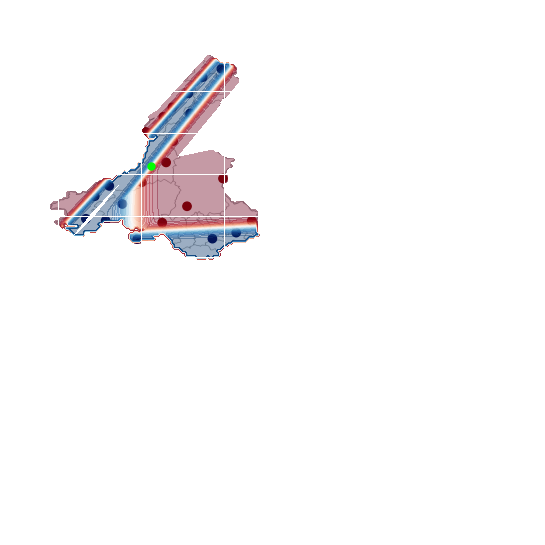

iteration  1
Accuracy is 0.44106902518746394
sim_anneal_isolated coord: (6.654325571402112, 9.298889719225055) distance: [[8.16110986]]
iteration  2
Accuracy is 0.46510286483368585
sim_anneal_isolated coord: (39.27970099135192, 45.457344196154544) distance: [[5.69371079]]
iteration  3
Accuracy is 0.46952509132859066
sim_anneal_isolated coord: (34.77598014346119, 43.40174012960301) distance: [[2.41376123]]
iteration  4
Accuracy is 0.47490867140934434
sim_anneal_isolated coord: (25.29953446809209, 33.84315210552856) distance: [[2.65598791]]
iteration  5
Accuracy is 0.4660642184195347
sim_anneal_isolated coord: (27.501272272454848, 36.157051927574784) distance: [[0.9962133]]
iteration  6
Accuracy is 0.4637569698134974
sim_anneal_isolated coord: (12.288425102038513, 17.211925373654218) distance: [[4.60337215]]
iteration  7
Accuracy is 0.47164006921745816
sim_anneal_isolated coord: (8.788568365996625, 14.74616993551742) distance: [[1.41448684]]
iteration  8
Accuracy is 0.5816189194385695
si

<IPython.core.display.Javascript object>


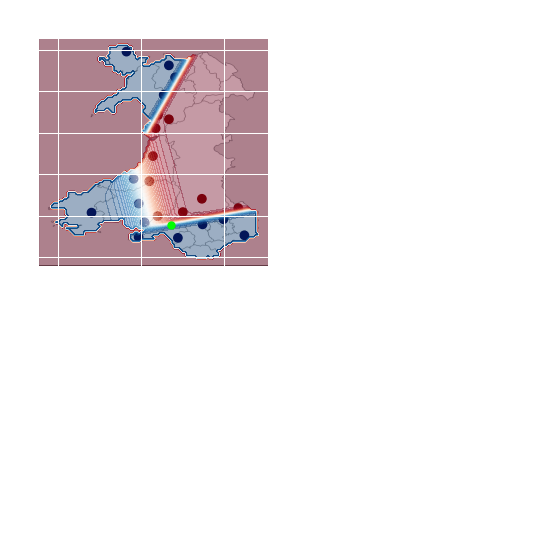

iteration  1
Accuracy is 0.5654681791963084
sim_anneal_isolated coord: (16.428272618761593, 49.55692182779787) distance: [[19.13933346]]
iteration  2
Accuracy is 0.5533551240146126
sim_anneal_isolated coord: (26.65591248593835, 33.26932831128953) distance: [[7.99648824]]
iteration  3
Accuracy is 0.5575850797923476
sim_anneal_isolated coord: (18.142489048300163, 18.92943590549945) distance: [[5.72050215]]
iteration  4
Accuracy is 0.5612382234185733
sim_anneal_isolated coord: (26.64478600651927, 46.246882510332796) distance: [[4.19787327]]
iteration  5
Accuracy is 0.5981542011151701
sim_anneal_isolated coord: (19.348346489315134, 4.900447551557825) distance: [[4.99286592]]
iteration  6
Accuracy is 0.5562391847721592
sim_anneal_isolated coord: (28.8145632302477, 4.705121996173782) distance: [[3.47423919]]
iteration  7
Accuracy is 0.6037300519130936
sim_anneal_isolated coord: (44.83165553831614, 5.303540305744638) distance: [[5.2866703]]
iteration  8
Accuracy is 0.6119976927513939
sim_anne

In [8]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            elif(selection_model==4):
                nextpoint = sim_anneal_best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [9]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 67.97 %
Improvement is = 11.42 %


In [11]:
np.savetxt('braninBestSimAnnealnn', Results)